In [68]:
# Basic
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

# System
import warnings
import os
warnings.filterwarnings("ignore")
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data

In [69]:
users = pd.read_csv('BX-Users.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1"

In [70]:
books = pd.read_csv('BX-Books.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [79]:
books_min = books[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher", "Image-URL-L"]]
books_min.ISBN.astype(int)
books_min.rename(columns={"Book-Title":"book_title",
                          "Image-URL-L":"image_url",
                          "Year-Of-Publication":"publication_year",
                          "Book-Author":"book_author",
                          "Publisher":"publisher"
                         },inplace=True)
books_min.to_csv("books_min.csv", header=None)

ValueError: invalid literal for int() with base 10: '074322678X'

In [4]:
ratings = pd.read_csv('BX-Book-Ratings.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')

In [5]:
data = pd.merge(ratings, users, on='User-ID', how='inner')

In [6]:
data = pd.merge(data, books, on='ISBN', how='inner')

In [7]:
# Check
data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [8]:
# Drop (TODO: image analysis?)
'''to_drop = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']

data = data.drop(to_drop, axis=1, inplace=False)'''

"to_drop = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']\n\ndata = data.drop(to_drop, axis=1, inplace=False)"

In [9]:
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

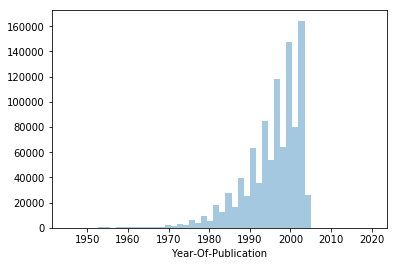

In [10]:
# Publication by Year
year = pd.to_numeric(data['Year-Of-Publication'], 'coerse').fillna(2099, downcast = 'infer')
sns.distplot(year, kde=False, hist_kws={"range": [1945,2020]})

In [11]:
country = data['Location'].apply(lambda row: str(row).split(',')[-1])
data.groupby(country)['Book-Rating'].count().sort_values(ascending=False).head(10)

Location
 usa               746466
 canada             93000
 united kingdom     33072
 germany            27657
                    24259
 australia          18238
 spain              14968
 n/a                11177
 france             10639
 portugal            6980
Name: Book-Rating, dtype: int64

## Change data-type

In [12]:
# Cast to numeric
data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'], 'coerse').fillna(2099, downcast = 'infer')

In [13]:
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

## Handle outliers

In [14]:
data['Age'] = np.where(data['Age']>90, None, data['Age'])

## Impute nulls

In [15]:
# Categorical feautes
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

In [16]:
# Check cat features
data[['Book-Author', 'Publisher']].isnull().sum()

Book-Author    0
Publisher      0
dtype: int64

In [17]:
# Age
median = data["Age"].median()
std = data["Age"].std()
is_null = data["Age"].isnull().sum()
rand_age = np.random.randint(median - std, median + std, size = is_null)
age_slice = data["Age"].copy()
age_slice[pd.isnull(age_slice)] = rand_age
data["Age"] = age_slice
data["Age"] = data["Age"].astype(int)

In [18]:
# Check Age
data['Age'].isnull().sum()

0

## Extract features

In [19]:
data['Country'] = data['Location'].apply(lambda row: str(row).split(',')[-1])

In [20]:
# Drop irelevant
data = data.drop('Location', axis=1)

In [21]:
data['Country'].head()

0     usa
1     usa
2     usa
3     usa
4     usa
Name: Country, dtype: object

# Prepeare dataset

In [22]:
df = data

In [23]:
# Relevant score
df = df[df['Book-Rating'] >= 6]

In [24]:
# Check
df.groupby('ISBN')['User-ID'].count().describe()

count    228991.000000
mean          3.728378
std          12.416496
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1206.000000
Name: User-ID, dtype: float64

In [25]:
df = df.groupby('ISBN').filter(lambda x: len(x) >= 5)

In [26]:
df.groupby('User-ID')['ISBN'].count().describe()

count    66526.000000
mean         8.234104
std         50.644099
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       5841.000000
Name: ISBN, dtype: float64

In [27]:
df = df.groupby('User-ID').filter(lambda x: len(x) >= 5)

In [28]:
df.shape

(469087, 12)

# Simple recommendation

In [29]:
df_p = df.pivot_table(index='ISBN', columns='User-ID', values='Book-Rating')

In [30]:
# Select users who liked LOTR
lotr = df_p.ix['0345339703'] # Lord of the Rings Part 1
like_lotr = lotr[lotr == 10].to_frame().reset_index()
users = like_lotr['User-ID'].to_frame()

In [31]:
# Trim original dataset
liked = pd.merge(users, df, on='User-ID', how='inner')

## Add measures (aggregate) 

In [32]:
rating_count = liked.groupby('ISBN')['Book-Rating'].count().to_frame()

In [33]:
rating_mean = liked.groupby('ISBN')['Book-Rating'].mean().to_frame()

In [34]:
rating_count.rename(columns={'Book-Rating':'Rating-Count'}, inplace=True)

In [35]:
rating_mean.rename(columns={'Book-Rating':'Rating-Mean'}, inplace=True)

In [36]:
liked = pd.merge(liked, rating_count, on='ISBN', how='inner')

In [37]:
liked = pd.merge(liked, rating_mean, on='ISBN', how='inner')

In [38]:
liked['Rating-Mean'] = liked['Rating-Mean'].round(2)

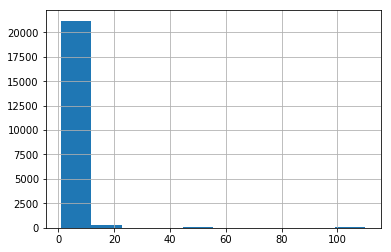

In [39]:
liked['Rating-Count'].hist()

In [40]:
C = liked['Rating-Mean'].mean()
C

8.269525959367936

In [41]:
m = rating_count.quantile(.995)[0] # .9
m

9.0

In [42]:
# IMDB formula; source: http://trailerpark.weebly.com/imdb-rating.html?source=post_page---------------------------
def weighted_rating(x, m=m, C=C):
    v = x['Rating-Count']
    R = x['Rating-Mean']

    return (v/(v+m) * R) + (m/(m+v) * C)

In [43]:
# Create relevant sub-dataset
liked_q = liked.copy().loc[liked['Rating-Count'] >= m]
liked_q.shape

(994, 14)

In [44]:
liked_q['Score'] = liked_q.apply(weighted_rating, axis=1)

## Best rated (TOP 10)

In [45]:
top_r = liked_q[['Book-Title', 'Rating-Mean']]

In [46]:
top_r = top_r.groupby(['Book-Title'])['Rating-Mean'].mean().to_frame()

In [47]:
top_r.sort_values(by='Rating-Mean', ascending=False).head(10)

,Rating-Mean
Book-Title,
"The Fellowship of the Ring (The Lord of the Rings, Part 1)",10.000000
The Hobbit : The Enchanting Prelude to The Lord of the Rings,9.670000
"The Return of the King (The Lord of the Rings, Part 3)",9.650000
To Kill a Mockingbird,9.640000
Anne of Avonlea (Anne of Green Gables Novels (Paperback)),9.600000
"The Two Towers (The Lord of the Rings, Part 2)",9.590000
Harry Potter and the Prisoner of Azkaban (Book 3),9.525238
Ender's Game (Ender Wiggins Saga (Paperback)),9.450000
The Phantom Tollbooth,9.440000


## Most popular (TOP 10)

In [48]:
top_p = liked[['Book-Title', 'Rating-Count']]

In [49]:
top_p = top_p.groupby(['Book-Title'])['Rating-Count'].mean().to_frame()

In [50]:
top_p.sort_values(by='Rating-Count', ascending=False).head(10)#.plot(kind='barh')

,Rating-Count
Book-Title,
"The Fellowship of the Ring (The Lord of the Rings, Part 1)",104.482759
"The Return of the King (The Lord of the Rings, Part 3)",51.037736
"The Two Towers (The Lord of the Rings, Part 2)",46.642857
The Hobbit : The Enchanting Prelude to The Lord of the Rings,30.000000
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),22.000000
The Da Vinci Code,19.000000
Interview with the Vampire,16.000000
A Time to Kill,15.117647
Harry Potter and the Chamber of Secrets (Book 2),14.793103


# Embedings (word2vec)

The idea behind this is that different movies are connected via the same user and thus will have high cosine similarity. What this truely shows is how books "travels" - remeber, this is book crossing project. For more information about word2vec see: http://www.bicorner.net/?p=194&preview=true

In [51]:
from tqdm import tqdm
from gensim.models import Word2Vec 
import random

In [52]:
users = df["User-ID"].unique().tolist()
len(users)

13484

In [53]:
# shuffle users ID's
random.shuffle(users)

# extract 90% of customer ID's
users_train = [users[i] for i in range(round(0.9*len(users)))]

# split data into train and validation set
train_df = df[df['User-ID'].isin(users_train)]
validation_df = df[~df['User-ID'].isin(users_train)]

In [54]:
# list to capture purchase history of the customers
reads_train = []

# populate the list with the product codes
for i in tqdm(users_train):
    temp = train_df[train_df["User-ID"] == i]["ISBN"].tolist()
    reads_train.append(temp)

100%|██████████| 12136/12136 [00:11<00:00, 1060.42it/s]


In [55]:
# list to capture purchase history of the customers
reads_val = []

# populate the list with the product codes
for i in tqdm(validation_df['User-ID'].unique()):
    temp = validation_df[validation_df["User-ID"] == i]["ISBN"].tolist()
    reads_val.append(temp)

100%|██████████| 1348/1348 [00:00<00:00, 1355.51it/s]


In [56]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(reads_train, progress_per=200)

model.train(reads_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3979180, 4225700)

In [57]:
model.init_sims(replace=True)

In [58]:
print(model)

Word2Vec(vocab=27030, size=100, alpha=0.03)


In [59]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(27030, 100)

In [60]:
books = train_df[["ISBN", "Book-Title"]]

# remove duplicates
books.drop_duplicates(inplace=True, subset='ISBN', keep="last")

# create product-ID and product-description dictionary
books_dict = books.groupby('ISBN')['Book-Title'].apply(list).to_dict()

In [61]:
books_with_urls = train_df[["ISBN", "Book-Title", "Image-URL-L", "Year-Of-Publication", "Book-Rating", "Book-Author"]]
books_with_urls.to_csv("books_with_urls.csv")

In [62]:
# Find LOTR
df[df['Book-Title'].str.contains('Lord of the Rings')].sample()

,User-ID,ISBN,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Country
324858,169438,0618129022,8,39,The Lord of the Rings (Movie Art Cover),J.R.R. Tolkien,2001,Houghton Mifflin Company,http://images.amazon.com/images/P/0618129022.0...,http://images.amazon.com/images/P/0618129022.0...,http://images.amazon.com/images/P/0618129022.0...,usa


In [63]:
# Check
books_dict['0345339703']

['The Fellowship of the Ring (The Lord of the Rings, Part 1)']

In [64]:
def similar_books(v, n = 15):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (books_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms 

In [65]:
# Recommend
similar_books(model['0345339703'])

[('The Two Towers (The Lord of the Rings, Part 2)', 0.876096248626709),
 ('The Return of the King (The Lord of the Rings, Part 3)',
  0.7856452465057373),
 ('Battlefield Earth: A Saga of the Year 3000', 0.7851578593254089),
 ('The Mists of Avalon', 0.774543285369873),
 ('Second Chance (Left Behind: The Kids #2)', 0.7726954221725464),
 ('Piercing the Darkness', 0.7721861004829407),
 ('Black Hawk Down (Movie Tie-in)', 0.7708324790000916),
 ('Lasher', 0.767447292804718),
 ('Rainbow Valley (Anne of Green Gables Novels (Paperback))',
  0.7656721472740173),
 ('Flatland: A Romance of Many Dimensions (Dover Thrift Editions)',
  0.7601386904716492),
 ('This Present Darkness', 0.7590639591217041),
 ('The Hobbit : The Enchanting Prelude to The Lord of the Rings',
  0.757118821144104),
 ("Anne's House of Dreams", 0.7558304071426392),
 ('OUT OF THE SILENT PLANET', 0.7553132772445679),
 ('Cold Fire', 0.7485856413841248)]

In [66]:
model.save('book_model')

In [67]:
import json
with open('books_dict.json', 'w') as f:
    json.dump(books_dict, f)